In [1]:
import pyKRLST
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process.kernels import RBF

In [2]:
def f(x):
    """The function to predict."""
    return x * np.sin(x)

# Observations
X = np.atleast_2d([1.0, 3.0, 5.0, 6.0, 7.0, 8.0]).T
y = f(X).ravel()

x = np.atleast_2d(np.linspace(0, 10, 1000)).T

kernel = RBF(2)                 # Kernel    
M = 5                           # Dictionary budget
lambda_ = 0.999                 # Forgetting factor
c = 1e-5                        # Noise-to-signal ratio (used for regulariation)
mode = "B2P"                    # Forget mode
krlst = pyKRLST.KRLST(kernel=kernel,
              l=lambda_, 
              c=c,
              M=M,
              forgetmode=mode)

# Train in online fashion using at most four basis elements
for t, a, b in zip(np.arange(10), X, y):
    krlst.train(a, b, t)

# Predict for unknown data
y_pred, y_std = krlst.eval(x)

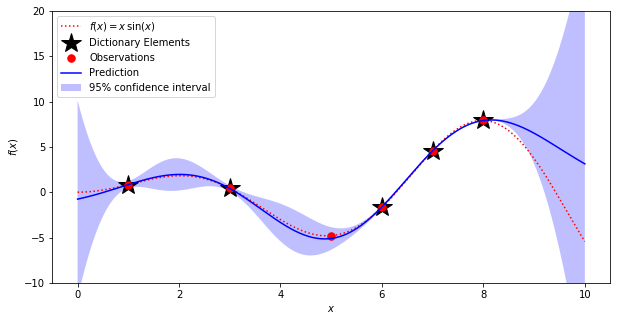

In [3]:
plt.figure(figsize=(10,5))
plt.plot(x, f(x), 'r:', label=r'$f(x) = x\,\sin(x)$')
plt.plot(krlst.Xb, krlst.mu, 'k.', markersize=20, marker="*",label="Dictionary Elements")
plt.plot(X, y, 'r.', markersize=15, label='Observations')
plt.plot(x, y_pred, 'b-', label='Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * y_std,
                        (y_pred + 1.9600 * y_std)[::-1]]),
         alpha=.25, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')
plt.show()